In [1]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets

import random

from typing import List, Dict, Tuple, Callable

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
INPUT_SIZE = (299, 299)

In [4]:
dataset_dir = "datasets/emotions"

In [5]:
def get_classes(path: str) -> Dict:
    classes = os.listdir(os.path.join(path, "train_class"))
    classes = {index: cls for index, cls in enumerate(classes)}
    return classes

classes = get_classes(dataset_dir)
classes

{0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise'}

In [6]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ]),
    "test": transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
}


In [7]:
batch_train = 128
batch_test = 32
shuffle = True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class:  anger


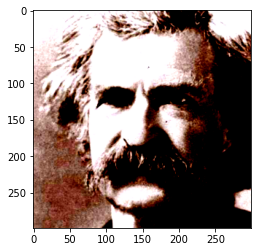

In [8]:
train_data = datasets.ImageFolder(root=os.path.join(dataset_dir, "train_class"), transform=data_transforms["train"])
test_data = datasets.ImageFolder(root=os.path.join(dataset_dir, "val_class"), transform=data_transforms["test"])

im, label = train_data[random.randint(0, len(train_data))]

print("Class: ", classes[label])
plt.imshow(im.permute(1,2,0).cpu())
plt.show()

dataloaders = {
    "train": DataLoader(train_data, batch_size=batch_train, shuffle=shuffle, drop_last=True),
    "test": DataLoader(test_data, batch_size=batch_test, shuffle=shuffle, drop_last=True),
}


In [9]:
feature_extracting = True
input_shape = (3, 299, 299)

In [10]:
from torchsummary import summary

def load_model(num_classes: int, feature_extracting: bool) -> Tuple:
    model = torchvision.models.inception_v3(pretrained=True)

    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

    num_fltrs = model.fc.in_features

    model.fc = nn.Sequential(nn.Flatten(),
                             nn.Linear(num_fltrs, 128),
                             nn.ReLU(),
                             nn.Linear(128, num_classes),
                             nn.Softmax(dim=1))

    model.aux_logits = False

    criter = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=0.001)

    return model.to(device), criter, opt

model, criterion, optimizer = load_model(len(classes), feature_extracting)

summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [10]:
def train_batch(X: torch.Tensor,
                y: torch.Tensor,
                model: nn.Module,
                criter: Callable[[torch.Tensor, torch.Tensor], float],
                optimizer:  optim.Optimizer) -> float:

    output = model(X)

    loss = criter(output, y)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    return loss.item()


@torch.no_grad()
def accuracy(X: torch.Tensor, y: torch.Tensor, model: nn.Module) -> float:
    model.eval()
    output = model(X)
    _, preds = torch.max(output, dim=1)
    correct = (preds == y).float().sum()
    return correct.item()


In [11]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

NameError: name 'model' is not defined

In [12]:
epochs = 3

In [14]:
def train_model(model: nn.Module,
                dataloaders: Dict[str, DataLoader],
                epochs: int,
                criter: Callable[[torch.Tensor, torch.Tensor], float],
                optimizer: optim.Optimizer) -> Tuple:

    train_acc, train_loss = [], []
    test_acc= []

    for epoch in range(epochs):
        print("Epoch {} / {}: ".format(epoch + 1, epochs))
        for phase in ["train", "test"]:
            print("Phase: ", phase)
            current_loss = 0
            current_correct = 0

            if phase == "train":
                model.train()
                for batch, (X, y) in enumerate(dataloaders[phase]):
                    
                    X, y = X.to(device), y.to(device)

                    batch_loss = train_batch(X, y, model, criter, optimizer)
                    correct = accuracy(X, y, model)

                    current_loss += batch_loss
                    current_correct += correct
                    

                epoch_loss = current_loss / len(dataloaders[phase])
                print(current_correct)
                epoch_acc = current_correct / len(train_data)

                
                print("Loss: {:.3f}, Accuracy: {:.3f}".format(epoch_loss, epoch_acc))

                train_acc.append(epoch_acc)
                train_loss.append(epoch_loss)

            if phase == "test":
            
                with torch.no_grad():
                    for X, y in dataloaders[phase]:
                     
                        X, y = X.to(device), y.to(device)
                        
                        correct = accuracy(X, y, model)

                        current_correct += correct


                    epoch_acc = current_correct / len(test_data)

                    print("Accuracy: {:.3f}".format(epoch_acc))
                    
                    test_acc.append(epoch_acc)


    torch.save(model, "models/EmotionsModel.pt")
    return train_acc, train_loss, test_acc


train_acc, train_loss, test_acc = train_model(model, dataloaders, epochs, criterion, optimizer)



Epoch 1 / 3: 
Phase:  train
10413.0
Loss: 1.992, Accuracy: 0.277
Phase:  test
Accuracy: 0.287
Epoch 2 / 3: 
Phase:  train
12292.0
Loss: 1.947, Accuracy: 0.327
Phase:  test
Accuracy: 0.304
Epoch 3 / 3: 
Phase:  train
12948.0
Loss: 1.929, Accuracy: 0.345
Phase:  test
Accuracy: 0.323


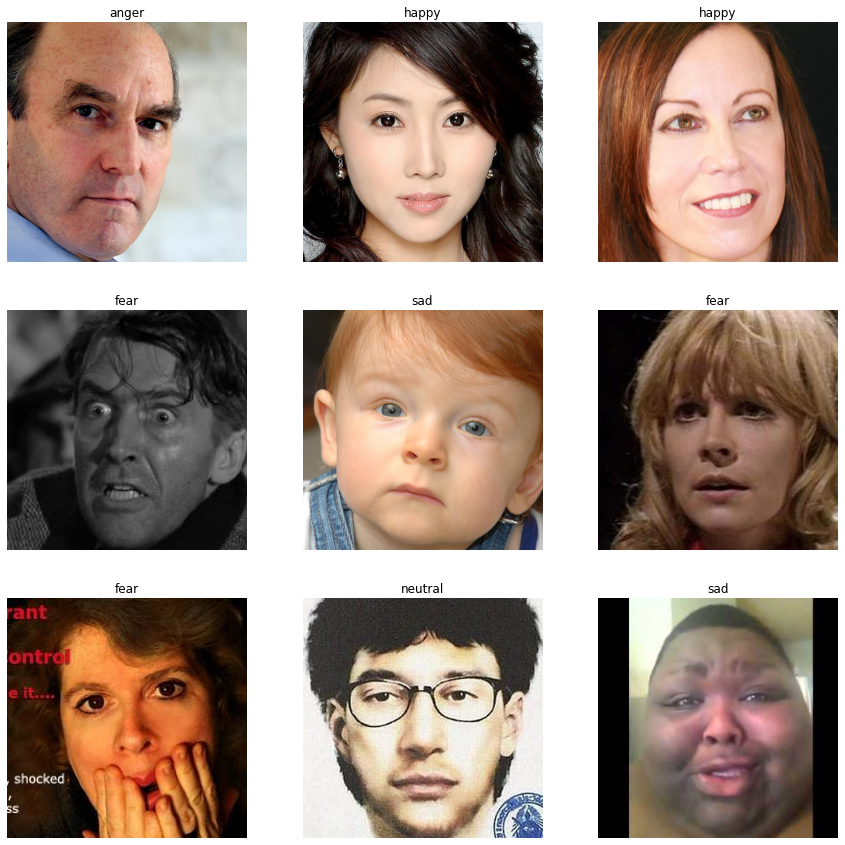

In [11]:
def predict(img: Image) -> int:
    from torch.autograd import Variable

    img = data_transforms["test"](img)
    img = img.unsqueeze(0).cuda()
    img = Variable(img).to(device)

    pred = model(img)
    cls = pred.data.cpu().numpy().argmax()
    return cls


def predict_k_images(imgs_paths: List, size: int) -> None:
    fig = plt.figure(figsize=(15, 15))

    imgs = random.sample(imgs_paths, size * size)

    for i in range(size * size):
        img = Image.open(imgs[i])
        index = predict(img)
        plt.subplot(size, size, i+1)
        plt.title(classes[index])
        plt.axis('off')
        plt.imshow(img)


model = torch.load("models/EmotionsModel.pt")
model.eval()

images_dir = "datasets/emotions/val_class"
dirs = [os.path.join(images_dir, f) for f in os.listdir(images_dir)]
pred_images = []
for d in dirs:
    pred_images.extend([os.path.join(d, f) for f in os.listdir(d)])

predict_k_images(pred_images, 3)

In [12]:
all_folders = {f:os.path.join(images_dir, f) for f in os.listdir(images_dir)}
all_folders

{'anger': 'datasets/emotions/val_class\\anger',
 'contempt': 'datasets/emotions/val_class\\contempt',
 'disgust': 'datasets/emotions/val_class\\disgust',
 'fear': 'datasets/emotions/val_class\\fear',
 'happy': 'datasets/emotions/val_class\\happy',
 'neutral': 'datasets/emotions/val_class\\neutral',
 'sad': 'datasets/emotions/val_class\\sad',
 'surprise': 'datasets/emotions/val_class\\surprise'}

In [13]:
predictions_classes = {cls: np.array([]) for cls in all_folders.keys()}


def get_all_predictions(cls: str) -> np.ndarray:
    path = os.path.join(images_dir, cls)
    imgs = [os.path.join(path, f) for f in os.listdir(path)]

    preds = []
    for img in imgs:
        img = Image.open(img)
        preds.append(predict(img))

    return np.array(preds)

for k in predictions_classes.keys():
    predictions_classes[k] = get_all_predictions(k)



In [14]:
predictions_classes

{'anger': array([0, 5, 0, 0, 7, 0, 7, 0, 5, 6, 0, 0, 0, 5, 0, 0, 7, 0, 5, 0, 3, 3,
        7, 4, 0, 4, 6, 0, 0, 5, 7, 0, 4, 0, 0, 0, 6, 0, 3, 0, 0, 5, 0, 6,
        0, 0, 3, 5, 5, 6, 0, 0, 7, 7, 6, 7, 0, 0, 0, 0, 0, 5, 0, 5, 5, 1,
        4, 0, 3, 3, 4, 1, 5, 6, 0, 0, 6, 5, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0,
        4, 4, 0, 5, 0, 0, 0, 6, 6, 0, 5, 3, 0, 7, 0, 0, 0, 5, 0, 7, 6, 0,
        1, 0, 6, 0, 0, 5, 0, 0, 3, 5, 7, 0, 0, 1, 5, 0, 0, 6, 0, 0, 0, 6,
        0, 0, 5, 5, 1, 0, 5, 5, 0, 0, 6, 5, 7, 6, 0, 0, 5, 0, 0, 3, 5, 5,
        3, 6, 3, 3, 0, 0, 5, 0, 0, 0, 0, 0, 0, 3, 3, 6, 0, 3, 6, 0, 5, 0,
        5, 6, 0, 0, 3, 0, 7, 7, 6, 6, 5, 5, 5, 7, 0, 5, 0, 7, 3, 0, 0, 3,
        7, 3, 0, 7, 0, 3, 0, 0, 0, 0, 0, 0, 4, 6, 1, 0, 0, 7, 5, 5, 0, 7,
        5, 0, 0, 0, 0, 5, 0, 0, 7, 0, 0, 0, 7, 5, 0, 0, 0, 6, 0, 0, 3, 6,
        4, 7, 0, 0, 0, 6, 3, 0, 0, 0, 5, 6, 0, 5, 0, 7, 0, 5, 3, 6, 6, 7,
        0, 1, 5, 0, 0, 0, 0, 3, 5, 4, 0, 0, 0, 3, 0, 4, 0, 7, 0, 0, 6, 0,
        0, 1, 0, 7, 6, 5, 0, 

In [15]:
predictions_list = np.array([])
for v in predictions_classes.values():
    predictions_list = np.append(predictions_list, v)

predictions_list.shape


(4000,)

In [16]:
reverse_emotion_classes = {v: k for k, v in classes.items()}
reverse_emotion_classes

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprise': 7}

In [17]:
true_labels = np.array([])

for cls in all_folders.keys():
    d = os.path.join(images_dir, cls)
    labels = [reverse_emotion_classes[cls] for f in os.listdir(d)]
    true_labels = np.append(true_labels, labels)

true_labels.shape

(4000,)

In [18]:
print(predictions_list.dtype)

float64


In [19]:
print(true_labels.dtype)

float64


In [20]:
from sklearn.metrics import classification_report

print(classification_report(predictions_list, true_labels, target_names=list(reverse_emotion_classes.keys())))

              precision    recall  f1-score   support

       anger       0.52      0.26      0.34      1006
    contempt       0.12      0.31      0.17       196
     disgust       0.00      0.00      0.00         0
        fear       0.42      0.41      0.41       517
       happy       0.50      0.45      0.48       553
     neutral       0.44      0.28      0.34       799
         sad       0.25      0.29      0.27       442
    surprise       0.33      0.34      0.33       487

    accuracy                           0.32      4000
   macro avg       0.32      0.29      0.29      4000
weighted avg       0.42      0.32      0.35      4000



<AxesSubplot:>

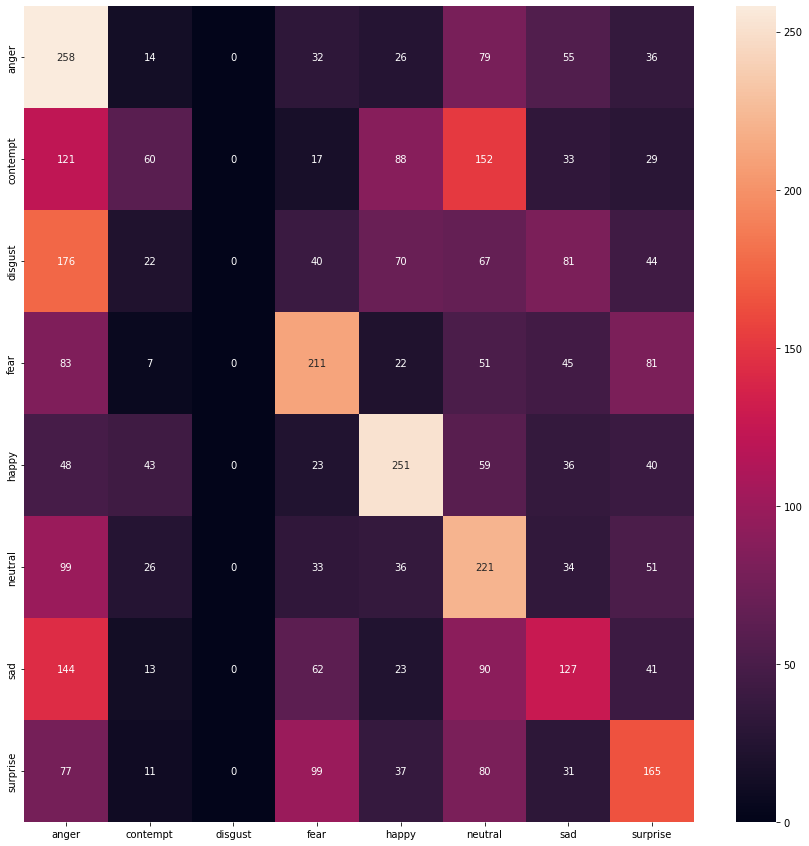

In [21]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

confusion = confusion_matrix(true_labels, predictions_list)

fig = plt.figure(figsize=(15, 15))
heatmap(confusion,
        annot=True,
        fmt="d",
        xticklabels=list(reverse_emotion_classes.keys()),
        yticklabels=list(reverse_emotion_classes.keys()))

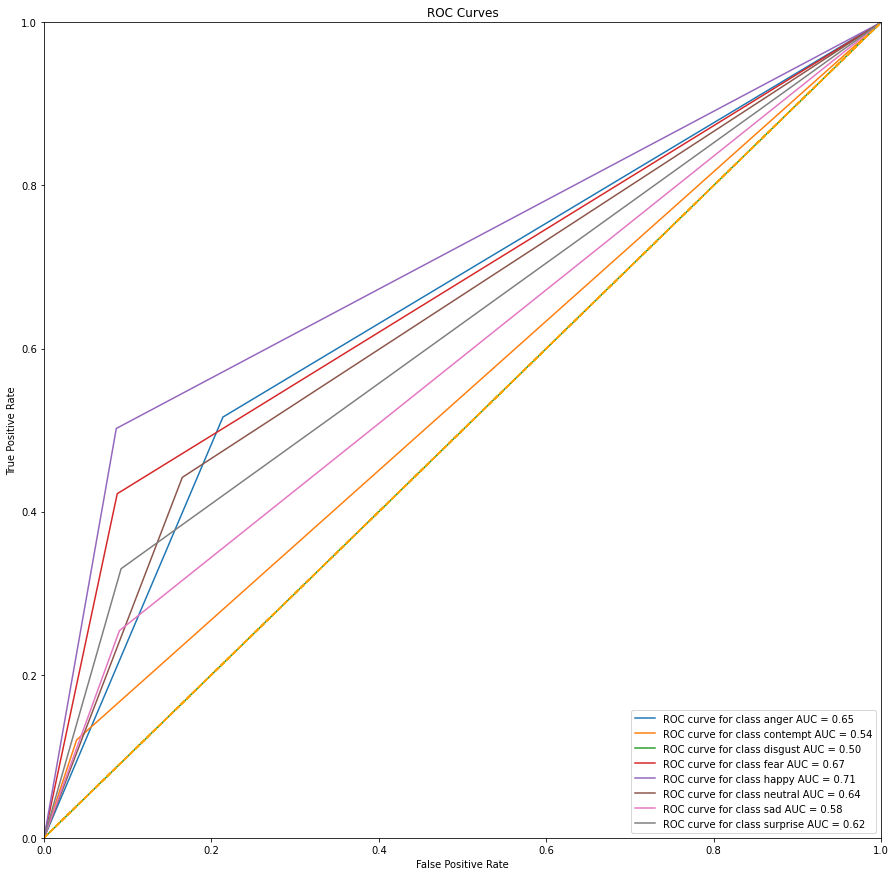

In [22]:
from sklearn.metrics import roc_curve, auc

fig = plt.figure(figsize=(15, 15))

def plot_roc_curves(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    true_for_class = [(y_true == float(i)) for i in list(classes.keys())]
    pred_for_class = [(y_pred == float(i)) for i in list(classes.keys())]
    
    fpr_tpr = [roc_curve(true_for_class[i], pred_for_class[i]) for i in list(classes.keys())]
    roc_auc = [auc(fpr_tpr[i][0], fpr_tpr[i][1]) for i in list(classes.keys())]
    
    plt.title("ROC Curves")
    
    for i in list(classes.keys()):
        plt.plot(fpr_tpr[i][0], fpr_tpr[i][1], label="ROC curve for class {} AUC = {:0.2f}".format(classes[i], roc_auc[i]))
        plt.legend(loc="lower right")
        plt.plot([0,1], [0,1], color='orange', linestyle='--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel("True Positive Rate")
        plt.xlabel("False Positive Rate")

    plt.show()
        

plot_roc_curves(true_labels, predictions_list)

### As we can see in upper results, emotions classifier we built is not very precise with its predictions and often mispredict class for image (0 predicts for class disgust in whole test dataset). However, this kind of behaviour is caused not by problems with model we use (inceptionv3 pretrained) but by problems in training dataset. If we consider in detail our dataset, we can see that a lot of images in this dataset are misslabled (e. g. some photoes that are labeled happy are in fact neutral or sad). There are also a lot of images where we cant see face clearly (e. g. mouth is hidden behind hand). These are main reasons why we cant get good precision on this dataset